# Process Obs-LE (Mckinnon) timeseries into variability data

__0. Is already at 5x5 deg resolution and on IPCC regions (separately).__

__1. Use Dask to perform resampling for variability spatially.__

Resample for time periods 2-63 years (to compare with 1960-2023 observations) to generate envelopes of internal variability for each region and each model.  

- Output is a dataArray for each model with indexed by time period length (2-63 years) and lat-lon gridcell containing unforced TAS trends.

- Should remove the forced trend before performing resampling.

## Code!

Most important taken from: trend_uncertainty/spatialdata_preproc.ipynb

In [16]:
import glob
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask

In [ ]:
# import sys,warnings
# # Add common resources folder to path
# sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/')
# sys.path.append('/glade/u/home/jonahshaw/Scripts/git_repos/internalvar-vs-obsunc/Common/')

# from imports import (
#     np, xr, plt, sns, os,
#     glob, dask, xe, pd
#     )

# %matplotlib inline

### Get files.

In [2]:
obsle_mc_dir = '/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS'

In [12]:
# obsle_spatial_filepaths = glob.glob('%s/*5x5deg.nc' % obsle_mc_dir)
obsle_spatial_filepaths = ['/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/TREFHT_Annual_1921-2014_ensmem1-1000.5x5deg.nc']
obsle_ipcc_filepaths    = glob.glob('%s/*IPCCregions.nc' % obsle_mc_dir)

## Define functions for resampling.

In [4]:
# need a wrapper function because you can't groupby multiple dimensions
def gettrends_wrapper2(dataarray,dim,sel_dim='time.year'):
    
    dataarray[dim] = dataarray[sel_dim]

    return dataarray.polyfit(dim=dim,deg=1)['polyfit_coefficients'].sel(degree=1)


def calc_slopes_spatial_ann2(data,_startyr,_endyr,wrapper_func):
    '''
    Separate function for the annual trends because I was dumb.
    '''
    
    tsel = data.sel(year=slice(None,_endyr))
    # print(len(tsel.year))
    
    slopes_endyr_ann = wrapper_func(tsel,dim='year',sel_dim='year').drop('degree')

    # slopes_endyr = xr.concat([slopes_endyr,slopes_endyr_ann.assign_coords({'month':13}).expand_dims('month',axis=-1)],dim='month')

    slopes_endyr_ann['startyear']  = int(_startyr)
    slopes_endyr_ann['duration'] = len(tsel.year)
    
    return slopes_endyr_ann


def calc_trends_noload(data:xr.DataArray,var:str,startyear:str,endyears:np.ndarray,
                       wrapper_func,calc_slopes_func):
    
    '''
    Takes data. Computes trends. Quietly and efficiently :)
    '''
    
    slopes_by_dur = []
    
    for _endyr in endyears: # Dasking here? Yessir.

        slopes_by_dur.append(calc_slopes_func(data=data,_startyr=int(startyear),_endyr=_endyr,wrapper_func=wrapper_func))

    forced_olrslopes_monthly = xr.concat(slopes_by_dur,dim='duration')
    forced_olrslopes_monthly.name=var
    
    return forced_olrslopes_monthly

### Perform Resampling

#### IPCC Regioned Data

Here, I can combine the seasonal data into annual data. I just need to be clear about how. Since it won't be a single calendar year.

__The solution here is for the "year" to begin in December and end in November. If I group by year, this will make everything line up, and I think it makes the most sense.__

In [14]:
ds_list = []

# open_mfdataset doesn't work for some reason. So I open and merge.
for _filepath in obsle_ipcc_filepaths:
    print(_filepath)
    ds_list.append(xr.open_dataset(_filepath))

all_ipcc_ds = xr.merge(ds_list)['TREFHT']

# We are concerned with annual average trends
all_ipcc_ann = all_ipcc_ds.groupby('time.year').mean(dim='time')

# Compute the forced response
all_ipcc_forcedresponse = all_ipcc_ann.mean(dim='samples')

# Compute the variability component by removing the forced trend
all_ipcc_variability = all_ipcc_ann - all_ipcc_forcedresponse

/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/TREFHT_SON_1921-2014_ensmem1-1000.IPCCregions.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/TREFHT_MAM_1921-2014_ensmem1-1000.IPCCregions.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/TREFHT_JJA_1921-2014_ensmem1-1000.IPCCregions.nc
/glade/u/home/jonahshaw/w/trend_uncertainty/nathan/OBS_LENS/mckinnon_OLENS/TREFHT_DJF_1921-2014_ensmem1-1000.IPCCregions.nc


In [33]:
%%time

save_path = obsle_mc_dir

# Set var
var = 'TREFHT'

# Set startyears and durations
# durations = np.arange(3,35)
# durations = np.arange(35,65)
startyears = np.arange(1921,1926)
durations = np.arange(3,90)

# Open multiple files. Faster with Dask client running.
data = all_ipcc_variability

slopes_by_dur = []

# Iterate and calculate trends
for _startyear in startyears:
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    while len(_startyear_str) < 4: # pad with zeros
        _startyear_str = '0' + _startyear_str
    
    data_ann_slice = data.sel(year=slice(_startyear,_startyear+durations[-1]))
    
    slopes_by_dur.append(dask.delayed(calc_trends_noload)(data=data_ann_slice,
                                                          var=var,
                                                          startyear=_startyear_str,
                                                          endyears=_endyears,
                                                          wrapper_func=gettrends_wrapper2,
                                                          calc_slopes_func=calc_slopes_spatial_ann2,
                                                          ))
    
    
    # There are 1000 realizations so I don't need the startyear dimension to get enough samples.
    if _startyear_str == '1950': break

slopes_by_dur_computed = dask.compute(*slopes_by_dur)
out_concat = xr.concat(slopes_by_dur_computed,dim='startyear').compute() # Concatenate along the iterating dimension. Not sure why another compute is needed here.

CPU times: user 16.2 s, sys: 763 ms, total: 16.9 s
Wall time: 18.3 s


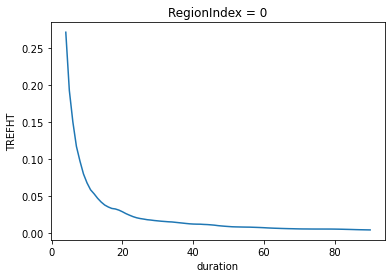

In [35]:
# out_concat.sel(RegionIndex=0,startyear=1921).std(dim=['samples']).plot()
out_concat.sel(RegionIndex=0).std(dim=['samples','startyear']).plot()

Now that is a nice, pretty smooth line! Weird that it isn't too smooth over 5000 samples...

In [37]:
out_concat.to_netcdf('%s/TREFHT_Annual_1921-2014.IPCCregions.Trends_startyears_1921_1925.nc' % obsle_mc_dir)

In [38]:
del out_concat

#### 5x5 degree data

Pre-pre-processing. Skip if the annual tseries has already been created.

In [89]:
ds_5x5_list = []

# open_mfdataset doesn't work for some reason. So I open and merge.
for _filepath in obsle_spatial_filepaths:
    
    ds_5x5_list.append(xr.open_mfdataset([_filepath])) # Use mfdataset to get it as a dask object

all_5x5_ds = xr.merge(ds_5x5_list)['TREFHT']

# We are concerned with annual average trends
all_5x5_ann = all_5x5_ds.groupby('time.year').mean(dim='time')

# Save the annual average because computing it takes a long time.
all_5x5_ann.to_netcdf('%s/TREFHT_Annual_1921-2014_ensmem1-1000.5x5deg.nc' % obsle_mc_dir)

del all_5x5_ann

Pre-processing.

In [39]:
all_5x5_ann = xr.open_dataarray('%s/TREFHT_Annual_1921-2014_ensmem1-1000.5x5deg.nc' % obsle_mc_dir)#,chunks={'year':-1,'lon':2})

In [41]:
%%time

# Compute the forced response
all_5x5_forcedresponse = all_5x5_ann.mean(dim='samples')

# Compute the variability component by removing the forced trend
all_5x5_variability = all_5x5_ann - all_5x5_forcedresponse

CPU times: user 1.03 s, sys: 1.44 s, total: 2.47 s
Wall time: 4.95 s


In [43]:
# Chunk pre-dasking
all_5x5_variability_chunkd = all_5x5_variability.chunk(chunks={'year':-1,'lon':2})

# Free up memory.
del all_5x5_variability, all_5x5_forcedresponse, all_5x5_ann

NameError: name 'all_5x5_forcedresponse' is not defined

The merging step is really slow if you have to load 8gb into a login node's memory...

In [45]:
%%time

save_path = obsle_mc_dir

# Set var
var = 'TREFHT'

# Set startyears and durations
# startyears = np.arange(1921,2000)
# durations = np.arange(3,65)
startyears = np.arange(1921,1926)
durations = np.arange(3,90)

# Open multiple files. Faster with Dask client running.
data = all_5x5_variability_chunkd

slopes_by_dur = []

# Iterate and calculate trends
for _startyear in startyears:
    print(_startyear, end="")
    _endyears = _startyear + durations
    _startyear_str = str(_startyear)
    
    while len(_startyear_str) < 4: # pad with zeros
        _startyear_str = '0' + _startyear_str
    
    data_ann_slice = data.sel(year=slice(_startyear,_startyear+durations[-1]))
    
    slopes_by_dur.append(dask.delayed(calc_trends_noload)(data=data_ann_slice,
                                                          var=var,
                                                          startyear=_startyear_str,
                                                          endyears=_endyears,
                                                          wrapper_func=gettrends_wrapper2,
                                                          calc_slopes_func=calc_slopes_spatial_ann2,
                                                         ))
    
    
    # There are 1000 realizations so I don't need the startyear dimension to get enough samples.
    if _startyear_str == '1922': break

slopes_by_dur_computed = dask.compute(*slopes_by_dur)
trends_5x5_concat = xr.concat(slopes_by_dur_computed,dim='startyear').compute() # Concatenate along the iterating dimension. Not sure why another compute is needed here.

CPU times: user 4min 49s, sys: 45.3 s, total: 5min 34s
Wall time: 5min 59s


Pretty smooth.

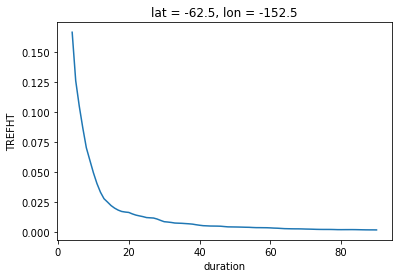

In [48]:
trends_5x5_concat.isel(lat=5,lon=5).std(dim=['samples','startyear']).plot()

In [47]:
trends_5x5_concat.to_netcdf('%s/TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1922.nc' % obsle_mc_dir)

#### The data was too big. (36 gB) So I broke it into smaller pieces to save.

In [3]:
trends_5x5_concat = xr.open_dataarray('%s/TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950.nc' % obsle_mc_dir,chunks={'samples':10})

In [18]:
%%time

for i in range(100):
    
    _sample_range = 10*i + np.arange(1,11,1)
    
    # print(_sample_range)
    
    _trend_5x5deg_subset = trends_5x5_concat.sel(samples=_sample_range)
    
    _outstring = 'TREFHT_Annual_1921-2014.5x5deg.Trends_startyears_1921_1950.Samples%d_%d.nc' % (_sample_range[0],_sample_range[-1])
    # print(_outstring)
    
    _trend_5x5deg_subset.to_netcdf('%s/%s/%s' % (obsle_mc_dir,'TREFHT_5x5deg_AnnualTrends',_outstring))
    
    print(i)
    # if i == 2: break
    # break

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
CPU times: user 15 s, sys: 1min 8s, total: 1min 23s
Wall time: 4min 37s


Looking good!

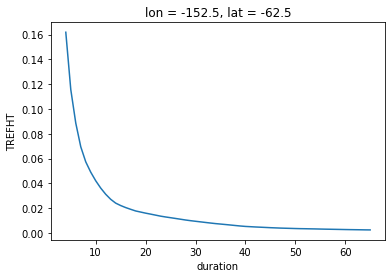

In [19]:
_trend_5x5deg_subset.isel(lat=5,lon=5).std(dim=['samples','startyear']).plot()